# DuyKhanh Nguyen
300316520

# Shringar 
3003356399

# Spam Classification Dectection - CSIS 4260 Project

# Referrences

### Datasets

https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv

https://www.kaggle.com/code/rohitshirudkar/email-classification-spam-or-ham

# 1. Prepare Data

In [1]:
# data
import pandas as pd
import numpy as np
import re
import string

# visualization
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from wordcloud import WordCloud


# nltk used for NLP
import nltk
# nltk.download()
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Preprocessing (sklearn)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
import itertools

# scoring
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, RocCurveDisplay

plt.style.use('ggplot')

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('Datasets/Uncleaned_Emails_1.csv')
df

Category                                            Message
0         ham  Go until jurong point, crazy.. Available only ...
1         ham                      Ok lar... Joking wif u oni...
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...
3         ham  U dun say so early hor... U c already then say...
4         ham  Nah I don't think he goes to usf, he lives aro...
...       ...                                                ...
5567     spam  This is the 2nd time we have tried 2 contact u...
5568      ham               Will ü b going to esplanade fr home?
5569      ham  Pity, * was in mood for that. So...any other s...
5570      ham  The guy did some bitching but I acted like i'd...
5571      ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [3]:
# Drop the uneeded columns


In [4]:
# Check null values
df.isnull().sum().sum()

0

# 2. EDA on features

## 2.1 Distribution of each categories

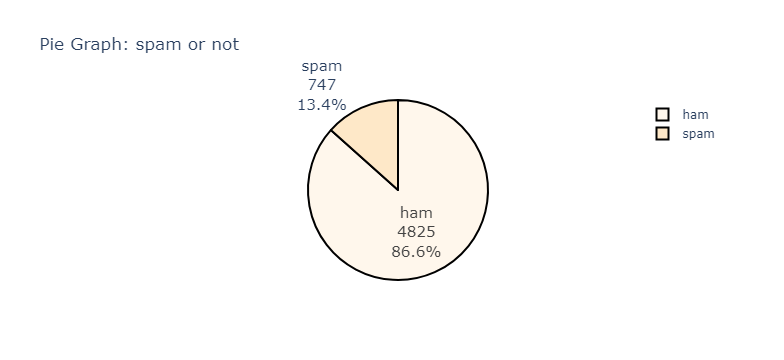

In [5]:
category_ct = df['Category'].value_counts()

fig = px.pie(values=category_ct.values, 
             names=category_ct.index, 
             color_discrete_sequence=px.colors.sequential.OrRd,
             title= 'Pie Graph: spam or not')
fig.update_traces(hoverinfo='label+percent', textinfo='label+value+percent', textfont_size=15,
                  marker=dict(line=dict(color='#000000', width=2)))
fig.show()


# 3. Text Preprocessing

## 3.1 Define functions

Here defined 8 functions, each are:
(1) get_all_str(): to get all of strings from dataframe column.
(2) get_str(): get string from list
(3) get_word(): to get words from text, using RegexpTokenizer
(4) stopword_list(): to add stopwords to nltp stopword list
(5) remove_stopword(): to remove stopwords from list
(6) Freq_df(): to get dataframe from cleanwordlist
(7) lemmatization(): to lemmatize words
and also visualization functions:

(8) Word_Cloud(): plot word cloud of words

In [6]:
# function to get all of strings from dataframe column, and used lower function here.
def get_all_str(df):
    sentence = ''
    for i in range(len(df)):
        sentence += df['Message'][i]
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

# function to get words from text(string). used RegexpTokenizer
def get_word(text): 
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
#     result = result.lower()                                              
#     result = nltk.word_tokenize(text)
    return result

# function to add stopwords to nltp stopword list.
def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

# function to remove stopwords from list.
def remove_stopword(words):
    cleanwordlist = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return cleanwordlist

# function to lemmatize words
def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
    return tokens

# function to remove hyperlink in message content
def remove_hyperlink(text):
    return re.sub(r"http\S+", "", text)

# function to remove number in message content, since number does not determine spam or not
def remove_number(text):
    result = re.sub(r'\d+', '', text)
    return result

# function to remove whitespace
def remove_whitespace(word):
    result = word.strip()
    return result

# function to remove newline
def remove_newline(text):
    return text.replace("\n", "")

# function to remove punctuation
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

# function to get dataframe from cleanwordlist.
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq



In [7]:
# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width = 800,
                  height = 400,
                  max_words =100,
                  colormap = colormap,
                  max_font_size = 140,
                  min_font_size = 2,
                  random_state = 42,
                  background_color = color_background).generate_from_frequencies(data)
    
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(title, fontsize = 20)
    plt.axis('off')
    plt.show()

## 3.2 Some Vizualization for Word Frequency

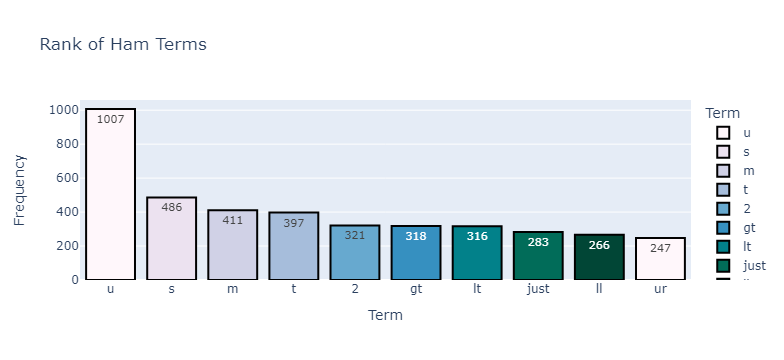

In [8]:
# Rank of Ham Terms
ham = df.loc[df["Category"] == "ham", "Message"].reset_index()
sentences = get_all_str(ham)
words = get_word(sentences)
cleanwordlist = remove_stopword(words)
freq_df = Freq_df(cleanwordlist)

top_10 = freq_df.head(10)

fig = px.bar(top_10, x = 'Term', y = 'Frequency', text = 'Frequency', color = 'Term',
            color_discrete_sequence = px.colors.sequential.PuBuGn, title = "Rank of Ham Terms")

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"
    
fig.update_traces(textposition = 'inside',
                  textfont_size = 11)

fig.show()

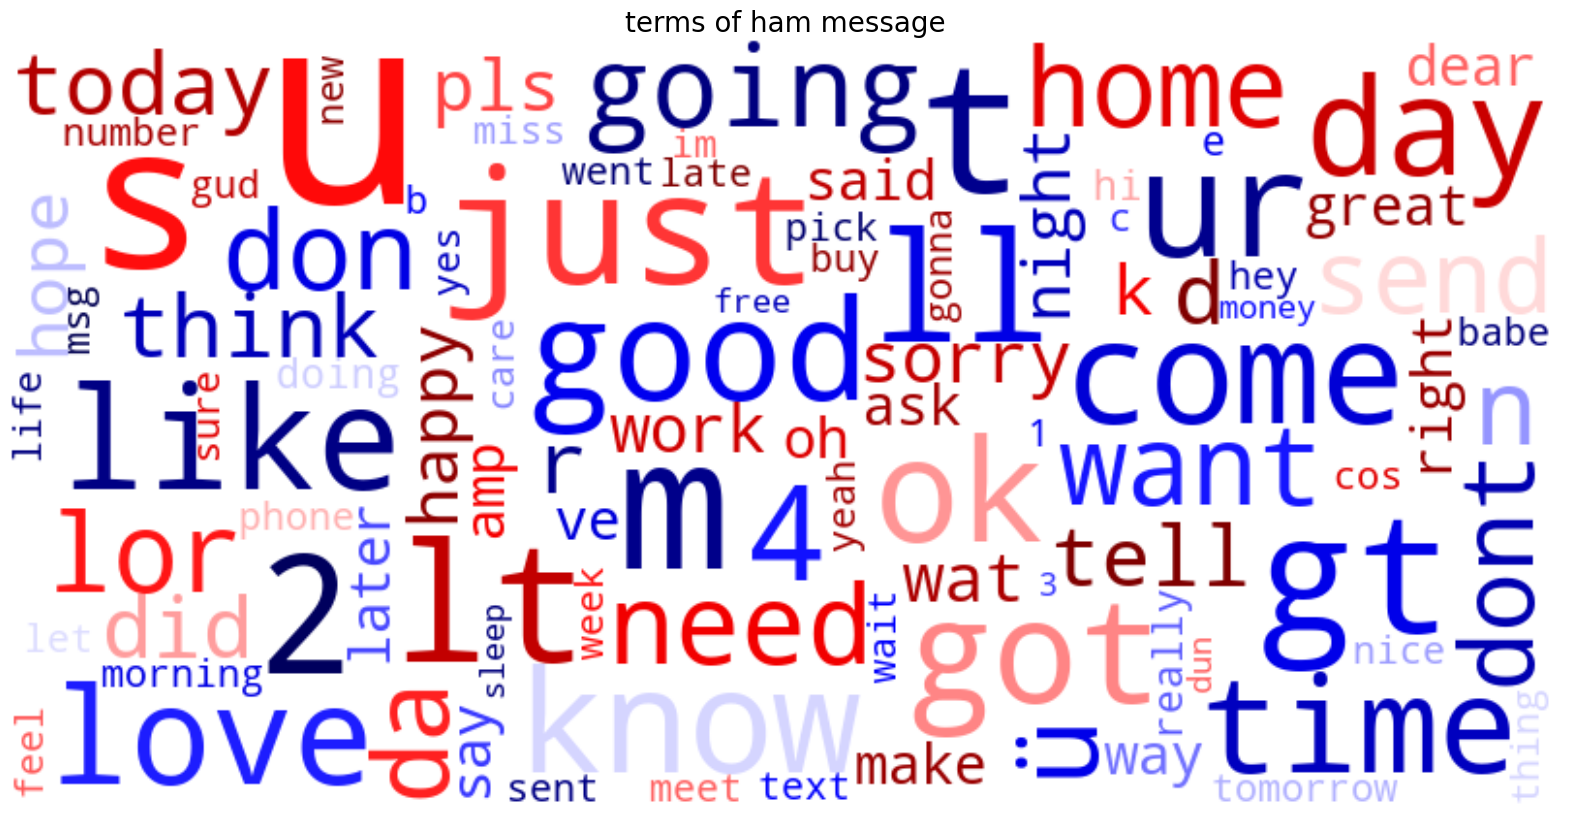

In [9]:
# Word Cloud of ham message
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
# data = freq_df.set_index('Term').to_dict()['Frequency']
data

ham_wordcloud = Word_Cloud(data, 'white', 'seismic', 'terms of ham message')

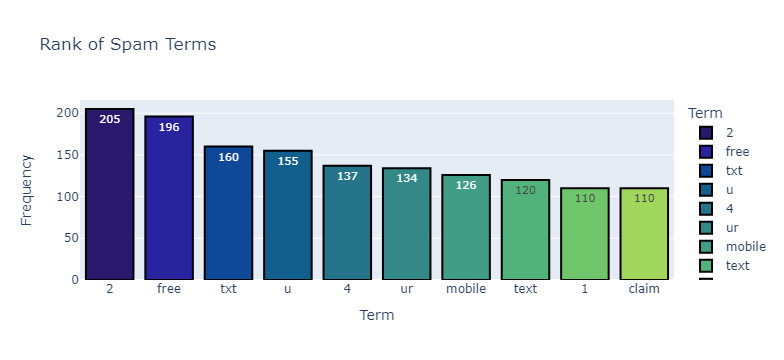

In [10]:
# Rank of Spam Terms
spam = df.loc[df["Category"] == "spam", "Message"].reset_index()
sentences = get_all_str(spam)
words = get_word(sentences)
cleanwordlist = remove_stopword(words)
freq_df = Freq_df(cleanwordlist)

top_10 = freq_df.head(10)

fig = px.bar(top_10, x = 'Term', y = 'Frequency', text = 'Frequency', color = 'Term',
            color_discrete_sequence = px.colors.sequential.haline, title = "Rank of Spam Terms")

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"
    
fig.update_traces(textposition = 'inside',
                  textfont_size = 11)

fig.show()


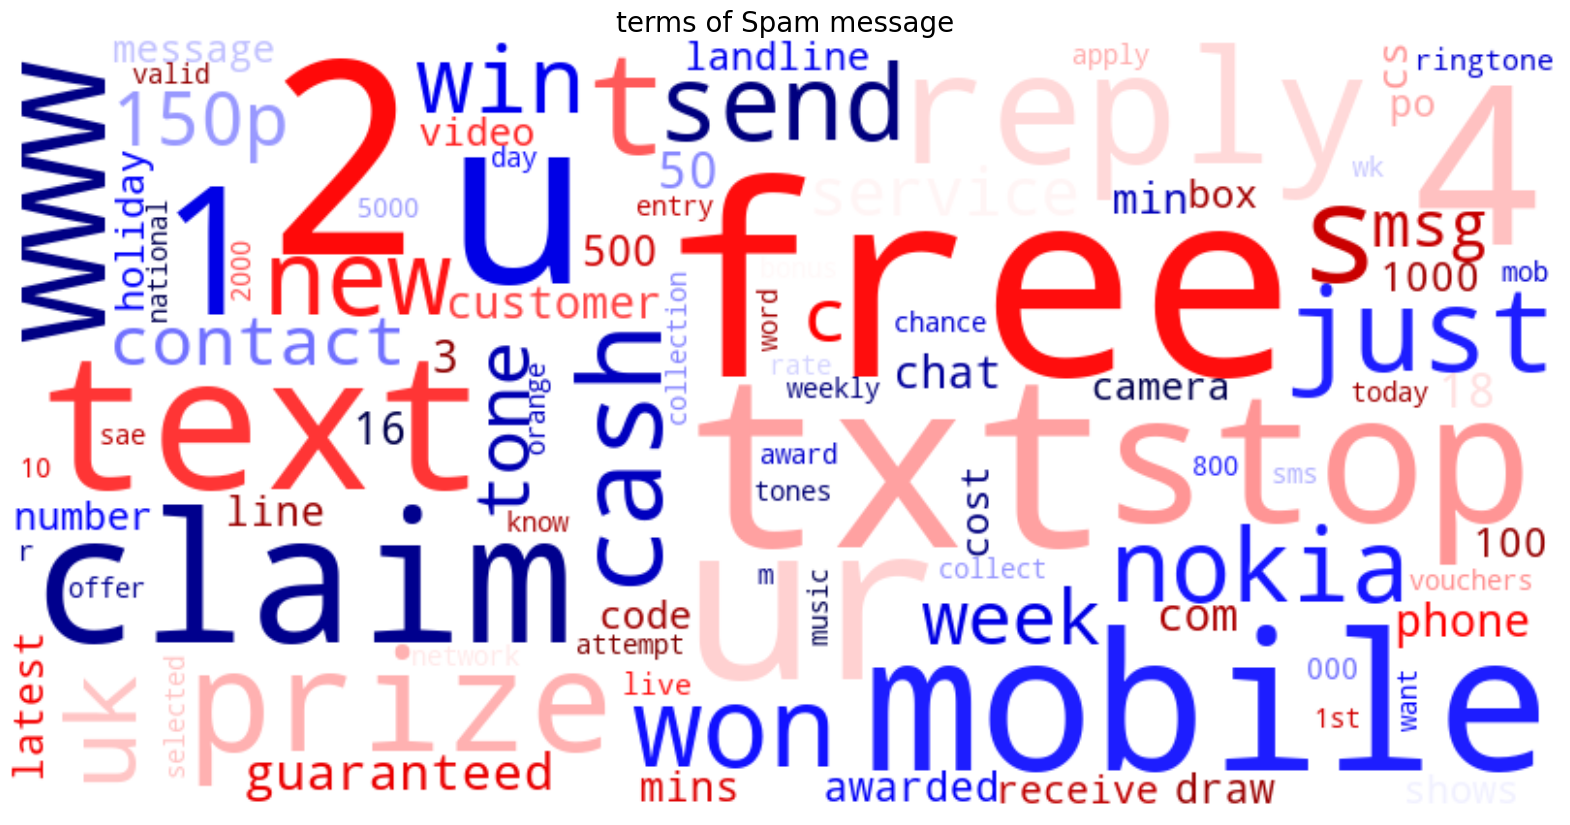

In [11]:
# Word Cloud of ham message
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
# data = freq_df.set_index('Term').to_dict()['Frequency']
data

ham_wordcloud = Word_Cloud(data, 'white', 'seismic', 'terms of Spam message')

### 3.3 Perform text preprocessing with these above functions for our dataframe

In [12]:
# Replace "ham" with 1 and "spam" as 0
df["Category"].replace('ham', 1, inplace = True)
df["Category"].replace('spam', 0, inplace = True)

In [13]:
# Using a pipeline to combine some text prepcrocessing function above
def clean_up_pipeline(text):
    function_list = [
        remove_hyperlink,
        remove_newline,
        remove_number,
        remove_punctuation,
        get_word,
        remove_stopword,
        lemmatization
    ]
    for function in function_list:
        text = function(text)
    return text
    # The reason we use the same name of paramater here is the output of the previous function will be the input of the next function in the Pipeline

In [14]:
clean_words = [clean_up_pipeline(text_row) for text_row in df["Message"]]

### Countvectorizer

In [15]:
# We will used Counvertorizer buildin function in sklearn.feature_extraction.text to convert our text dataframe in to a vertor of term counts


In [16]:
vector = CountVectorizer(analyzer = lambda x: x)
X = vector.fit_transform(clean_words)

### tf-idf transformer

In [17]:
# We will tranfsorm a count matrix to a normolizaed tf-idf prepresentation
X = TfidfTransformer().fit_transform(X)

# 3. Classification Models

In [18]:
target = df['Category']
features = X

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.25, random_state = 42)

### 3.1 Buidling Models and its hyperparameters

In [20]:
# Create a List to contains all the models
models_list = []

# Logistict Regression Hyperparameters
Cs = [0.0001, 1, 1000]
multi_classes = ['auto', 'ovr', 'multinomial']
hyperparams = list(itertools.product(Cs, multi_classes))
# Logsitic Regression bulding models
for C, multi_class in hyperparams:
    model = LogisticRegression(n_jobs= -1, C = C, multi_class = multi_class)
    model_name = "Logistic Regression with C = {}, and multi_class = {}".format(C, multi_class) 
    models_list.append([model_name, model])

# KNN Hyperparameters
leaf_sizes = list(range(1, 3))
n_neighbors = list(range(1, 3))
hyperparams = list(itertools.product(leaf_sizes, n_neighbors))
# KNN building models
for leaf_size, n_neighbor in hyperparams:
    model = KNeighborsClassifier(n_jobs= -1, leaf_size = leaf_size, n_neighbors = n_neighbor)
    model_name = "KNN with leaf_size = {}, and n_neighbor = {}".format(leaf_size, n_neighbor) 
    models_list.append([model_name, model])


# SVC Hyperparameters
gammas = [0.1, 1, 10]
Cs = [0.0001, 1, 1000]
hyperparams = list(itertools.product(gammas, Cs))
# Linear SVC
for gamma, C in hyperparams:
    model = SVC(kernel = "linear", gamma = gamma, C = C)
    model_name = "Linear SVC with gamma = {}, and C = {}".format(gamma, C) 
    models_list.append([model_name, model])
# RBF SVC
for gamma, C in hyperparams:
    model = SVC(kernel = "rbf", gamma = gamma, C = C)
    model_name = "RBF SVC with gamma = {}, and C = {}".format(gamma, C) 
    models_list.append([model_name, model])

# # Decision Tree Hyperparameters
# criterions = ["gini", "entropy", "log_loss"]
# splitters = ["best", "random"]
# hyperparams = list(itertools.product(criterions, splitters))
# for criterion, splitter in hyperparams:
#     model = DecisionTreeClassifier(criterion = criterion, splitter = splitter)
#     model_name = "Decision Tree with criterion = {}, and splitter = {}".format(criterion, splitter) 
#     models_list.append([model_name, model])
    
# # Naive Bayes Hyperparameters
# var_smoothings = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2]
# for var_smoothing in var_smoothings:
#     model = GaussianNB(var_smoothing = var_smoothing)
#     model_name = "Naive Bayes with var_smoothing = {}".format(var_smoothing) 
#     models_list.append([model_name, model])
    
# Random Forest Hyperparameters
criterions = ["gini", "entropy", "log_loss"]
n_estimators = [100, 150, 200]
hyperparams = list(itertools.product(criterions, n_estimators))
for criterion, n_estimator in hyperparams:
    model = RandomForestClassifier(n_jobs = -1, criterion = criterion, n_estimators = n_estimator)
    model_name = "RandomForestClassifier with criterion = {}, and n_estimators = {}".format(criterion, n_estimator) 
    models_list.append([model_name, model])
    
# AdaBoost Hyperparameters
learning_rates = [0.1, 1, 10]
n_estimators = [100, 150, 200]
hyperparams = list(itertools.product(learning_rates, n_estimators))
for learning_rate, n_estimator in hyperparams:
    model = AdaBoostClassifier(learning_rate = learning_rate, n_estimators = n_estimator)
    model_name = "AdaBoostClassifier with learning_rate = {}, and n_estimators = {}".format(learning_rate, n_estimator) 
    models_list.append([model_name, model])

# # XGBoost Hyperparameters
# learning_rates = [0.1, 0.5, 1]
# n_estimators = [100, 150, 200]
# hyperparams = list(itertools.product(learning_rates, n_estimators))
# for learning_rate, n_estimator in hyperparams:
#     model = XGBClassifier(n_jobs = -1, learning_rate = learning_rate, n_estimators = n_estimator, use_label_encoder = False)
#     model_name = "XGBClassifier with criterion = {}, and n_estimators = {}".format(learning_rate, n_estimator) 
#     models_list.append([model_name, model])

# # CatBoost Hyperparameters
# learning_rates = [0.1, 0.5, 1]
# iterationses = [5, 10, 20]
# hyperparams = list(itertools.product(learning_rates, iterationses))
# for learning_rate, iterations in hyperparams:
#     model = CatBoostClassifier(learning_rate = learning_rate, iterations = iterations)
#     model_name = "CatBoostClassifier with criterion = {}, and iterations = {}".format(learning_rate, iterations) 
#     models_list.append([model_name, model])

# ANN
first = [300, 200, 100, 50]
second = [200, 100, 50, 25]
for i in range(4):
    model = MLPClassifier(hidden_layer_sizes = (first[i], second[i]), max_iter = 1000, random_state = 42)
    model_name = "MLPClassifier with first layer size = {}, and second layer size = {}".format(first[i], second[i])
    models_list.append([model_name, model])

### 3.2 Create a pipeline for feature selectionm, scaler, and each of all models with its hyperparameters

In [21]:
# Create a pipeline for all models with its hyperparameters
scores = []
names = []
pipe_list = []
for model in models_list:
    pipe = Pipeline([
        # ("Matrix Transformer", FunctionTransformer(lambda x: x.todense(), accept_sparse = True)),
        ("Classifier", model[1])
    ])
    pipe.fit(X_train, Y_train)
    pipe_list.append(pipe)
    score = pipe.score(X_test, Y_test)
    scores.append(score)
    name = model[0]
    names.append(name)
    

### 3.3 Sorting the score result and choose the best model

In [22]:
scores_df = pd.DataFrame(zip(names, scores), columns = ["Classifier", "Accuracy"])
print(scores_df.sort_values(by= "Accuracy", ascending = False).to_markdown())

|    | Classifier                                                               |   Accuracy |
|---:|:-------------------------------------------------------------------------|-----------:|
| 52 | MLPClassifier with first layer size = 50, and second layer size = 25     |   0.983489 |
| 49 | MLPClassifier with first layer size = 300, and second layer size = 200   |   0.983489 |
| 18 | Linear SVC with gamma = 1, and C = 1000                                  |   0.983489 |
| 15 | Linear SVC with gamma = 0.1, and C = 1000                                |   0.983489 |
| 21 | Linear SVC with gamma = 10, and C = 1000                                 |   0.983489 |
| 51 | MLPClassifier with first layer size = 100, and second layer size = 50    |   0.983489 |
| 24 | RBF SVC with gamma = 0.1, and C = 1000                                   |   0.982771 |
| 50 | MLPClassifier with first layer size = 200, and second layer size = 100   |   0.982053 |
|  6 | Logistic Regression with C = 1000, and mult

### 3.4 Select the best pipe. Base on the score table above, we have the best pipe is

In [23]:
print(scores_df.sort_values(by= "Accuracy", ascending = False).head(1).to_markdown())

|    | Classifier                                                           |   Accuracy |
|---:|:---------------------------------------------------------------------|-----------:|
| 52 | MLPClassifier with first layer size = 50, and second layer size = 25 |   0.983489 |


In [24]:
# Make prediction and analyze its performace by creating the confusion matrix and classification report
best_pipe_index = scores_df.sort_values(by= "Accuracy", ascending = False).head(1).index.values[0]
best_pipe = pipe_list[best_pipe_index]
best_pipe.fit(X_train, Y_train)
Y_pred = best_pipe.predict(X_test)

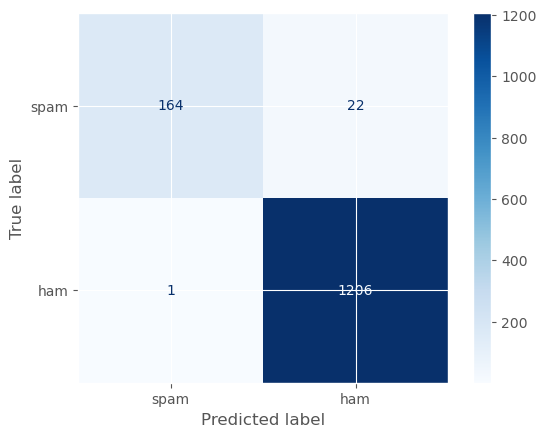

In [25]:
# Confusion Matrix of the best model
data = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=data, display_labels=['spam','ham'])
disp.plot(cmap='Blues')

In [26]:
# Classification Report
cr = classification_report(Y_test, Y_pred, output_dict = True)
cr_df = pd.DataFrame(cr)
cr_df

0            1  accuracy    macro avg  weighted avg
precision    0.993939     0.982085  0.983489     0.988012      0.983668
recall       0.881720     0.999171  0.983489     0.940446      0.983489
f1-score     0.934473     0.990554  0.983489     0.962514      0.983066
support    186.000000  1207.000000  0.983489  1393.000000   1393.000000

# 4. Out of Sample Prediction